In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sksurv.ensemble import RandomSurvivalForest 
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.pipeline import  make_pipeline
from sksurv.metrics import concordance_index_censored,concordance_index_ipcw
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import joblib
import seaborn as sns


In [2]:
train = pd.read_csv('./data/pre_early/HCC OP 20230511 train_early_input_derived features_std.csv')
test = pd.read_csv('./data/pre_early/HCC OP 20230511 test_early_input_derived features_std.csv')
display(train.head())

,Milan_out,Age,Sex,"Image_Vasulcar_invasion(Portal vein,Hepatic vein)",BCLC,Child_Class,Weight,Height,BMI,WBC,...,lnALT,lnAST,lnAFP,lnGGT,lnCHOL,lnALK-P,lnLDH,lnGLU,Early recur,Early RFS
0,-0.839707,-0.563829,-0.541987,-0.234619,-0.141611,-0.112784,0.375391,0.385409,0.200255,-0.781764,...,0.372630,-0.162916,-0.681794,0.793550,-0.007075,-0.256713,0.962504,1.029077,1.0,20.93
1,1.190892,0.101100,-0.541987,4.262237,2.849556,-0.112784,-1.545001,1.245869,-2.389457,-0.432036,...,-0.765823,-0.211990,0.705743,0.861633,0.237629,0.039598,0.269376,-0.620243,1.0,20.50
2,1.190892,-1.135863,-0.541987,-0.234619,-0.141611,-0.112784,1.664188,0.871756,1.308842,1.466488,...,-0.581277,-0.314623,0.270098,-0.248143,1.232400,0.011685,0.146332,-0.218720,0.0,24.00
3,-0.839707,0.309705,1.845062,-0.234619,-0.141611,-0.112784,-1.912009,-2.083737,-1.204985,-0.631881,...,-0.581277,-0.368371,-0.814056,-0.678009,0.901520,-0.103615,-0.142671,0.319989,0.0,24.00
4,-0.839707,-1.273575,1.845062,-0.234619,-0.141611,-0.112784,-1.801053,-0.799282,-1.764203,-0.531958,...,-0.640313,0.299748,0.356618,-0.387537,0.832357,0.300963,1.450717,-1.453071,0.0,13.70


In [3]:
selected = ['Tumor size', 'BCLC', 'class_AFP' ,'lnAST', 'lnALK-P' ,'AST' ,'ALBIgrade',
 'HBsAg' ,'HCV' ,'class_PTINR' ,'Height', 'K' ,'ALK-P', 'Tumor number']

In [4]:
X = train[ selected ]
y_struct = train[['Early recur', 'Early RFS']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])


In [5]:
coxnet = CoxnetSurvivalAnalysis()
coxnet.fit(X, y_struct)
print("fitted.")

fitted.


In [6]:
preds_train = coxnet.predict(X)
concordance_index_censored(train['Early recur'] > 0, train['Early RFS'],preds_train)

#concordance_index_ipcw((censored_test, survival_test, preds ))

(0.7336000369688208, 222250, 80708, 0, 58)

In [7]:
test_X_std = test[train.columns].drop(columns=['Early recur', 'Early RFS'])
test_X_std = test_X_std[selected]

In [8]:
y_struct_test = test[['Early recur', 'Early RFS']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

In [9]:
preds = coxnet.predict(test_X_std)
concordance_index_censored(test['Early recur'] > 0, test['Early RFS'],preds)
#concordance_index_ipcw(y_struct,y_struct_test , preds)

(0.7231024833857992, 41347, 15833, 0, 7)

In [10]:
from sklearn.metrics import roc_auc_score

# 假設您已經建立好並適配了 Cox 模型，並命名為 `cox_model`
# 請確保您的模型已經適配了訓練數據

# 使用 Cox 模型預測風險分數
predicted_scores = coxnet.predict(test_X_std)

# 計算 AUC
auc = roc_auc_score(test['Early recur'], predicted_scores)

print("AUC:", auc)

AUC: 0.742616585961698


In [25]:
# 將模型保存到文件
joblib.dump(coxnet, './result/OP_early_coxnet_model.joblib')

['./result/OP_early_coxnet_model.joblib']

CoxPH

In [11]:
cph = CoxPHSurvivalAnalysis()
cph.fit(X, y_struct)
print("fitted.")

fitted.


In [12]:
test_X_std = test[train.columns].drop(columns=['Early recur', 'Early RFS'])
test_X_std = test_X_std[selected]

In [13]:
preds_train = cph.predict(X)
concordance_index_censored(train['Early recur'] > 0, train['Early RFS'],preds_train)

(0.7332567550617577, 222146, 80812, 0, 58)

In [14]:
preds = cph.predict(test_X_std)
concordance_index_censored(test['Early recur'] > 0, test['Early RFS'],preds)

(0.722525358516964, 41314, 15866, 0, 7)

In [15]:
from sklearn.metrics import roc_auc_score

# 假設您已經建立好並適配了 Cox 模型，並命名為 `cox_model`
# 請確保您的模型已經適配了訓練數據

# 使用 Cox 模型預測風險分數
predicted_scores = cph.predict(test_X_std)

# 計算 AUC
auc = roc_auc_score(test['Early recur'], predicted_scores)

print("AUC:", auc)

AUC: 0.7418749727348077


In [30]:
# 將模型保存到文件
joblib.dump(cph, './result/OP_early_coxph_model.joblib')

['./result/OP_early_coxph_model.joblib']

In [14]:
for i in range(len(test_X_std)):
    print("ID: {}, Risk Score: {}".format(test_X_std.index[i], preds[i]))

ID: 0, Risk Score: 0.15433679467914807
ID: 1, Risk Score: 1.2721895544311577
ID: 2, Risk Score: 0.5829809858311206
ID: 3, Risk Score: 0.8568001283407217
ID: 4, Risk Score: -0.2748698538050796
ID: 5, Risk Score: -0.31717280084470745
ID: 6, Risk Score: 0.6850944306854112
ID: 7, Risk Score: 0.24345287665294907
ID: 8, Risk Score: 0.2633162219068401
ID: 9, Risk Score: -0.23483023409261172
ID: 10, Risk Score: 0.2589353154906855
ID: 11, Risk Score: 0.42537400581588436
ID: 12, Risk Score: -0.10045920065274455
ID: 13, Risk Score: -0.22617813568984363
ID: 14, Risk Score: -0.1916055452949582
ID: 15, Risk Score: 0.16266127635043487
ID: 16, Risk Score: 0.9439458494173605
ID: 17, Risk Score: 0.7237598429932703
ID: 18, Risk Score: -0.05133363596236752
ID: 19, Risk Score: -0.5847901377660265
ID: 20, Risk Score: 0.19876655300486945
ID: 21, Risk Score: 0.12732731097064004
ID: 22, Risk Score: 0.002517332013693821
ID: 23, Risk Score: -0.036925538337527625
ID: 24, Risk Score: -0.4735857700305541
ID: 25, Ri

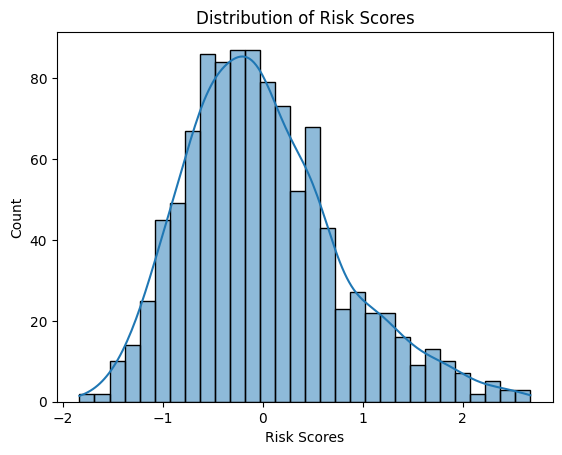

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of Risk Scores')
plt.show()

以人數30%切點切出risk score當作threshold

Threshold at 30%: -0.4244191102017738


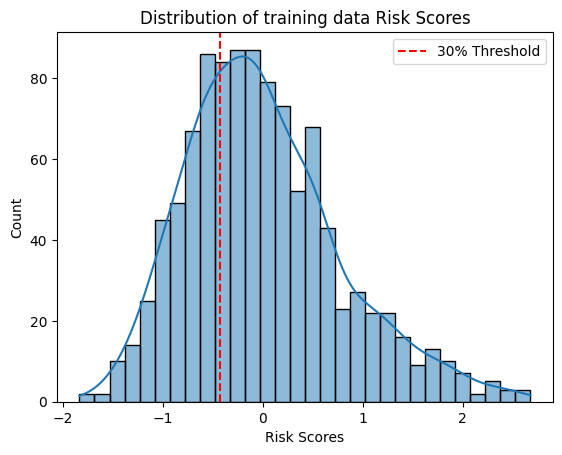

In [41]:
# 將 preds_train 由低至高排序
sorted_preds = sorted(preds_train)

# 計算第 70% 的索引位置
index_70_percent = int(0.32 * len(sorted_preds))

# 印出第 70% 的數值
threshold_70_percent = sorted_preds[index_70_percent]
print("Threshold at 30%:", threshold_70_percent)

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')
plt.axvline(x=threshold_70_percent, color='red', linestyle='--', label='30% Threshold')
plt.legend()
# plt.savefig('./data_cluster/統計圖表/train1.png')
plt.show()

以train的95%信賴區間切三等份當作threshold

Cut Point 1: -1.2485442530631845
Cut Point 2: 1.8505131351420279


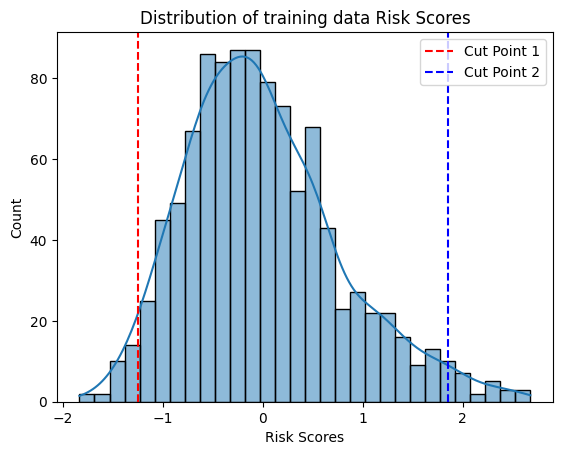

In [42]:
import numpy as np

# 計算 95% 信賴區間
lower_bound = np.percentile(preds_train, 2.5)
upper_bound = np.percentile(preds_train, 97.5)

# 將信賴區間分成三等分的切點
cut_points = [lower_bound, upper_bound]

# 分割資料成三個區間
low_data = preds_train[preds_train <= cut_points[0]]
medium_data = preds_train[(preds_train > cut_points[0]) & (preds_train < cut_points[1])]
high_data = preds_train[preds_train >= cut_points[1]]

# 列印切點數值
print("Cut Point 1:", cut_points[0])
print("Cut Point 2:", cut_points[1])

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')

# 繪製切點垂直線
plt.axvline(x=cut_points[0], color='red', linestyle='--', label='Cut Point 1')
plt.axvline(x=cut_points[1], color='blue', linestyle='--', label='Cut Point 2')
plt.legend()
plt.show()


Cut Point 1: -0.21552512366144705
Cut Point 2: 0.8174940057402904


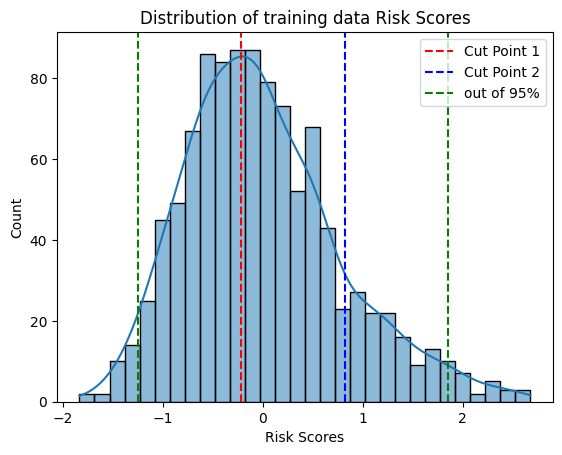

In [43]:
import numpy as np

# 計算 95% 信賴區間
lower_bound = np.percentile(preds_train, 2.5)
upper_bound = np.percentile(preds_train, 97.5)
cut_points = [lower_bound, upper_bound]
# 將信賴區間切成三等份的切點
cut_point1 = lower_bound + (upper_bound - lower_bound) / 3
cut_point2 = lower_bound + (upper_bound - lower_bound) * 2 / 3

# 列印切點數值
print("Cut Point 1:", cut_point1)
print("Cut Point 2:", cut_point2)

# 繪製直方圖
sns.histplot(preds_train, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of training data Risk Scores')

# 繪製切點垂直線
plt.axvline(x=cut_point1, color='red', linestyle='--', label='Cut Point 1')
plt.axvline(x=cut_point2, color='blue', linestyle='--', label='Cut Point 2')
plt.axvline(x=cut_points[0], color='green', linestyle='--', label='out of 95%')
plt.axvline(x=cut_points[1], color='green', linestyle='--')
plt.legend()
#plt.savefig('./data_cluster/統計圖表/train 95% .png')
plt.show()


In [ ]:
preds_train = coxnet.predict(X)

In [10]:
train['riskscore'] = coxnet.predict(X)

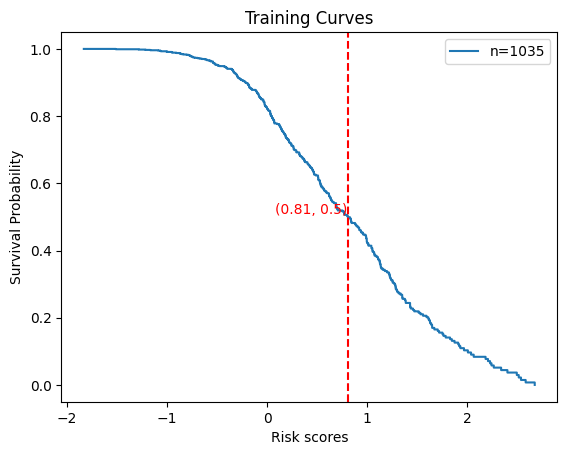

In [13]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
# time_high, survival_prob_high = kaplan_meier_estimator(test['riskscore'].astype("bool"),test['Recurrence free survival'])
time_high, survival_prob_high = kaplan_meier_estimator(train['Early recur'].astype("bool"),train['riskscore'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count = len(train)
plt.step(time_high, survival_prob_high, where="post",label=f'n={count}')
plt.xlabel('Risk scores')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Training Curves')
plt.legend()
# 找到 ylabel 為 0.5 的對應 xlabel 數值
ylabel_0_5 = 0.5
index = np.abs(survival_prob_high - ylabel_0_5).argmin()
xlabel_at_0_5 = time_high[index]
plt.axvline(x=xlabel_at_0_5, color='red', linestyle='--')
plt.text(xlabel_at_0_5, ylabel_0_5, f'{xlabel_at_0_5.round(2),ylabel_0_5}', color='red', ha='right', va='bottom')


plt.savefig('./result/統計圖表/Training Curves(OP_early).png')
plt.show()

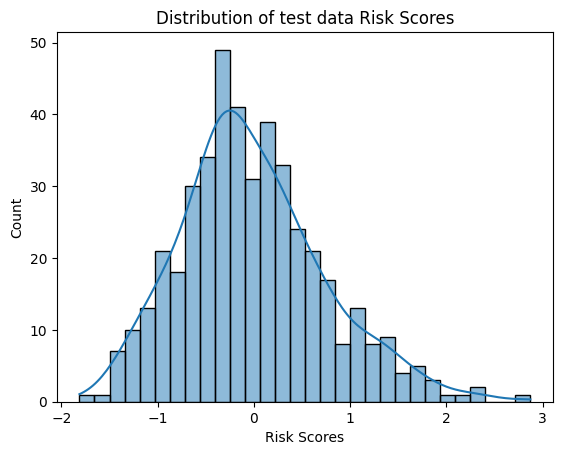

In [44]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(preds, bins=30, kde=True, edgecolor='black')
plt.xlabel('Risk Scores')
plt.ylabel('Count')
plt.title('Distribution of test data Risk Scores')
#plt.savefig('./data_cluster/統計圖表/test1.png')
plt.show()


In [56]:
train_low = train[ preds_train <=-0.21 ]
train_med = train[ (preds_train > -0.21) & (preds_train <0.81) ]
train_high = train[ preds_train >= 0.81 ]

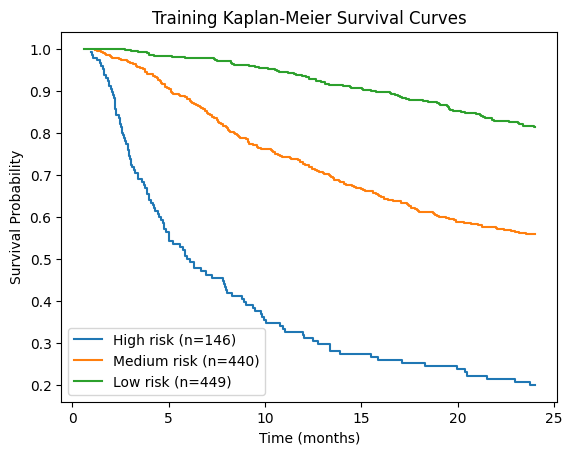

In [61]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(train_high['Early recur'].astype("bool"),train_high['Early RFS'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(train_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_med, survival_prob_med = kaplan_meier_estimator(train_med['Early recur'].astype("bool"),train_med['Early RFS'])
#plt.plot(time_med, survival_prob_med, drawstyle='steps-post', label="steps-post")
count_med = len(train_med)
plt.step(time_med, survival_prob_med, where="post",label=f'Medium risk (n={count_med})')

time_low, survival_prob_low = kaplan_meier_estimator(train_low['Early recur'].astype("bool"),train_low['Early RFS'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(train_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

#plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Training Kaplan-Meier Survival Curves')
plt.legend()
#plt.savefig('./result/統計圖表/Training kmplot high low med.png')
plt.show()


In [58]:
test_low = test[ preds <=-0.21 ]
test_med = test[ (preds > -0.21) & (preds <0.81) ]
test_high = test[ preds >= 0.81 ]

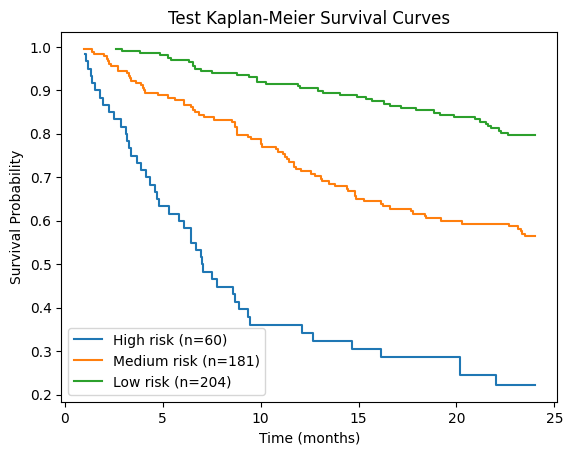

In [60]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(test_high['Early recur'].astype("bool"),test_high['Early RFS'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_med, survival_prob_med = kaplan_meier_estimator(test_med['Early recur'].astype("bool"),test_med['Early RFS'])
#plt.plot(time_med, survival_prob_med, drawstyle='steps-post', label="steps-post")
count_med = len(test_med)
plt.step(time_med, survival_prob_med, where="post",label=f'Medium risk (n={count_med})')

time_low, survival_prob_low = kaplan_meier_estimator(test_low['Early recur'].astype("bool"),test_low['Early RFS'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

#plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Test Kaplan-Meier Survival Curves')
plt.legend()
#plt.savefig('./result/統計圖表/test kmplot high low med.png')
plt.show()


In [15]:
test_low = test[ preds <= 0.81]
test_high = test[ preds > 0.81  ]

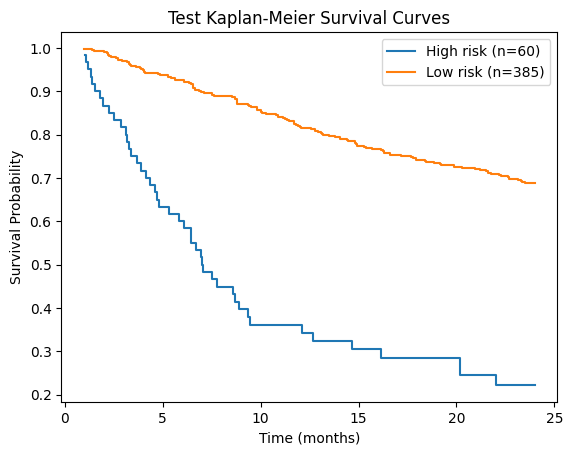

In [16]:
from sksurv.nonparametric import kaplan_meier_estimator, nelson_aalen_estimator
import matplotlib.pyplot as plt
time_high, survival_prob_high = kaplan_meier_estimator(test_high['Early recur'].astype("bool"),test_high['Early RFS'])
#plt.plot(time_high, survival_prob_high, drawstyle='steps-post', label="steps-post")
count_high = len(test_high)
plt.step(time_high, survival_prob_high, where="post",label=f'High risk (n={count_high})')

time_low, survival_prob_low = kaplan_meier_estimator(test_low['Early recur'].astype("bool"),test_low['Early RFS'])
#plt.plot(time_low, survival_prob_low, drawstyle='steps-post', label="steps-post")
count_low = len(test_low)
plt.step(time_low, survival_prob_low, where="post",label=f'Low risk (n={count_low})')

# plt.axvline(x=24, color='red', linestyle='--', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Survival Probability')
# 設定圖表的標題
plt.title('Test Kaplan-Meier Survival Curves')
plt.legend()
plt.savefig('./result/統計圖表/Test km_plot high low(OP_early).png')
plt.show()


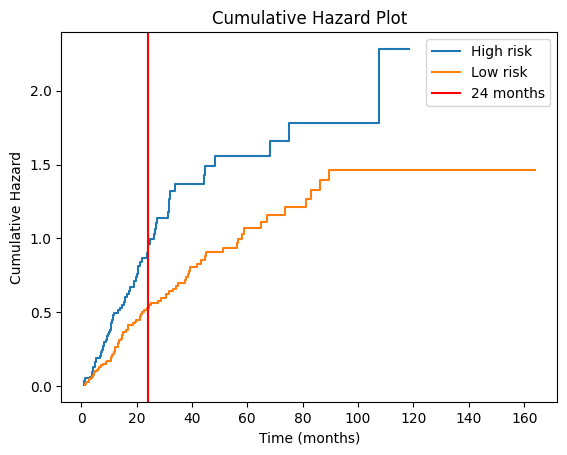

In [48]:
from sksurv.nonparametric import nelson_aalen_estimator
import matplotlib.pyplot as plt

mask_high = preds > 0
mask_low = preds <= 0

event_high = test['Recur'][mask_high].astype(bool)
time_high = test['Recurrence free survival'][mask_high]
time_high, cumulative_hazard_high = nelson_aalen_estimator(event_high, time_high)

event_low = test['Recur'][mask_low].astype(bool)
time_low = test['Recurrence free survival'][mask_low]
time_low, cumulative_hazard_low = nelson_aalen_estimator(event_low, time_low)

plt.step(time_high, cumulative_hazard_high, where="post", label='High risk')
plt.step(time_low, cumulative_hazard_low, where="post", label='Low risk')

plt.axvline(x=24, color='red', linestyle='-', label='24 months')

# 設定 x 軸、y 軸的名稱
plt.xlabel('Time (months)')
plt.ylabel('Cumulative Hazard')
# 設定圖表的標題
plt.title('Cumulative Hazard Plot')
plt.legend()
plt.show()


建立非線性模型

In [23]:
train = pd.read_csv('./data/RFA_lnV2_noISD_train_0419_std.csv')
test = pd.read_csv('./data/RFA_lnV2_noISD_test_0419_std.csv')

In [24]:
selected = ['lnPLAT','CR' ,'APRI' ,'FIB4' ,'BUN', 'Tumor size' ,'PTINR' ,'lnALT','Child_Class','AFP' ,'Weight']#gen=100 conv_gen=30 survtree

In [25]:
X = train[ selected ]
y_struct = train[['Recur', 'Recurrence free survival']].to_records(index=False).astype([('Status', 'bool'), ('Survival', 'float64')])

In [26]:
test_X_std = test[train.columns].drop(columns=['Recur', 'Recurrence free survival'])
test_X_std = test_X_std[selected]

SurvivalTree

In [27]:
from sksurv.tree import SurvivalTree

estimator = SurvivalTree().fit(X, y_struct)

preds = estimator.predict(test_X_std)

concordance_index_censored(test['Recur'] > 0, test['Recurrence free survival'],preds)


(0.5157909381811436, 10834, 10153, 576, 1)

In [29]:
preds = estimator.predict(X)
concordance_index_censored(train['Recur'] > 0, train['Recurrence free survival'],preds)

(0.8682501376010838, 102287, 15310, 498, 25)

RandomSurvivalForest

In [47]:
combined[ (combined['Recur']==1) & (combined['Recurrence free survival'] <=24) ].index

Int64Index([  0,   2,   4,   5,   8,   9,  10,  11,  13,  14,
            ...
            137, 138, 139, 140, 142, 143, 144, 146, 147, 149],
           dtype='int64', length=355)

<AxesSubplot: ylabel='Count'>

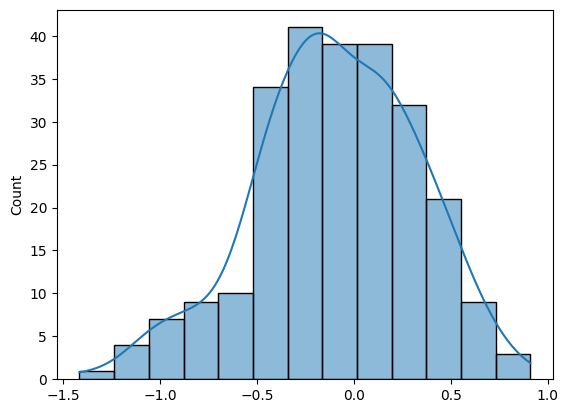

In [53]:
sns.histplot([ preds_all[idx] for idx in combined[ (combined['Recur']==0)  ].index ], kde=True)

<AxesSubplot: ylabel='Count'>

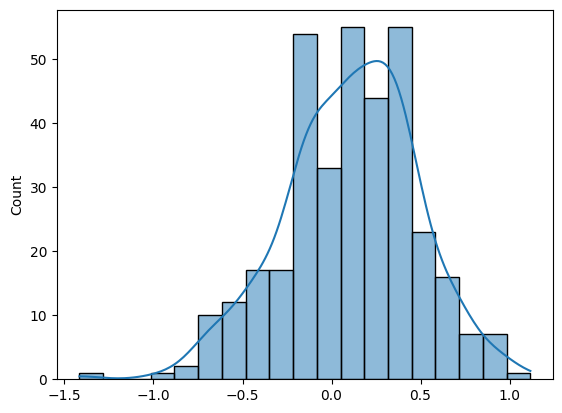

In [51]:
sns.histplot([ preds_all[idx] for idx in combined[ (combined['Recur']==1) & (combined['Recurrence free survival'] <=24) ].index ], kde=True)